# Tutorial

Welcome to the **iminuit tutorial**. You will learn basic usage of iminuit and how to approach standard fitting problems with iminuit. iminuit is a numerical minimizer and error calculator. You provide it an analytical function, which accepts one or several parameters, and an initial guess of the parameter values. It will then find a local minimum of this function starting from the initial guess. In that regard, iminuit is similar to other minimizers, like those in scipy.optimize.

In addition, iminuit has the ability to compute **uncertainty estimates** for model parameters. iminuit was designed to solve statistics problems, where uncertainty estimates are an essential part of the result. Two ways of computing uncertainty estimates are provided with different strengths, the *Hesse* and the *Minos* algorithm.

iminuit is the successor of pyminuit. If you used pyminuit before, you will find iminuit very familiar. An important feature of iminuit (and pyminuit) is that it uses introspection to detect the parameter names of your function. This is very convenient, especially when you work interactively in a Jupyter notebook. It also provides special output routines for Jupyter notebooks to pretty print the fit results, as you will see below.

In [35]:
# basic setup of the notebook
%pylab inline
from pprint import pprint # we use this to pretty print some stuff later

Populating the interactive namespace from numpy and matplotlib


/home/hdembinski/Code/conda/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['bar', 'fmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Fit example

For this tutorial, we look at a simple case where line should be fitted to scattered $(x, y)$ data. A line has two parameters $(a, b)$.

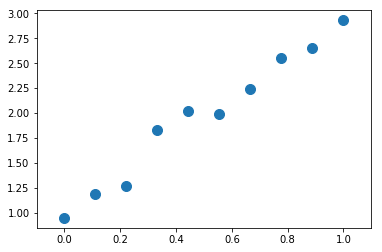

In [36]:
def line(x, a, b):
    return a + x * b

data_x = linspace(0, 1, 10)
# precomputed random numbers from a normal distribution
offsets = array([-0.49783783, -0.33041722, -1.71800806,  1.60229399,  1.36682387,
                 -1.15424221, -0.91425267, -0.03395604, -1.27611719, -0.7004073 ])
data_y = line(data_x, 1, 2) + 0.1 * offsets # generate some data points with random offsets
plot(data_x, data_y, "o")
xlim(-0.1, 1.1);

To recovert the parameters of the line, we fit the line to the scattered data using the method of least-squares. We compute the sum of squared residuals of the $y$ values around the line for a given pair of line parameters $(a, b)$.

In [37]:
def least_squares(a, b):
    yvar = 0.01
    return sum((data_y - line(data_x, a, b)) ** 2 / yvar)

With iminuit we can find the values of $a$ and $b$ which minimize this sum.

iminuit was designed to make it easy to fit functions like `least_squares(a, b)`, where the parameters are individual arguments of the function.

There is an alternative function signature that Minuit supports, which is more convenient when you work a lot with numpy. Here, the parameters are passed as a numpy array. The two kinds of function definitions have each pros and cons. We will first show how to work with functions of the first kind and come back to the second kind later. If you are interested only in the second kind, skip to the section **Alternative: Numpy functions**

## Initialize Minuit

To minimize a function, you create an instance of the Minuit class and pass the function to it. This does not start the minimization yet, this will come later. iminuit uses introspection to get the number and names of the function parameters automatically.

In [38]:
# everything in iminuit is done through the Minuit object, so we import it
from iminuit import Minuit

In [39]:
m = Minuit(least_squares) # we create an instance of Minuit and pass the function to minimize

/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter a does not have initial value. Assume 0.
  """Entry point for launching an IPython kernel.
/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
  """Entry point for launching an IPython kernel.
/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter b does not have initial value. Assume 0.
  """Entry point for launching an IPython kernel.
/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
  """Entry point for launching an IPython kernel.
/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: errordef is not given. Default to 1.
  """Entr

Woah, lots of warnings, we will go through them step-by-step. Note how iminuit refers to your parameters by correct names in the warnings. The filename and line numbers shown in the warnings are bogus in Jupyter notebooks, but refer to the correct file and line when you use iminuit in a script or in the terminal shell.

### Initial parameter values

iminuit is a local minimizer. It searches for a local minimum by gradient-descent method from a starting point. If your function has several minima, the minimum found will depend on the starting point. Even if it has only one minimum, iminuit will converge to it faster if you start in the proximity of the minimum. If you don't provide a starting value for a parameter, it uses 0. You almost always want to specify a starting point.

You can set the starting point using the parameter names as keywords, `<name> = <value>`.

In [40]:
m = Minuit(least_squares, a=5, b=5) # pass starting values for a and b

/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter a is floating but does not have initial step size. Assume 1.
  """Entry point for launching an IPython kernel.
/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: Parameter b is floating but does not have initial step size. Assume 1.
  """Entry point for launching an IPython kernel.
/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: errordef is not given. Default to 1.
  """Entry point for launching an IPython kernel.


### Initial step sizes

iminuit further wants initial step sizes. iminuit uses a gradient-descent method to find the minimum and the gradient is computed numerically using finite differences. The initial step size is used to compute the first gradient. If you don't provide a value, it uses 1. A good step size is small compared to the curvature of the function, but large compared to numerical resolution.

You can set initital step sizes with keywords, `error_<name> = <step size>`. If you don't know what to pick, don't worry too much. Usually, the choice is not important. In the worst case, iminuit will use a few more function evaluations to find the minimum. A good guess is a fraction of the initial fit parameter value, e.g. 10 % (be careful when applying this rule-of-thumb when your the initial parameter value is zero).

Using an appropriate step size is important when you have you a parameter which has physical bounds. Varying the initial parameter value by the step size may not create a situation where the parameter goes outside of its bounds. For example, a parameter $x$ with $x > 0$ and initital value $0.1$ may not have a step size of $0.2$. If you follow the recommendation of using 10 % of the initial value, you never run into this problem.

In our example, we use an initital step size of $\Delta a = \Delta b = 0.1$.

In [41]:
m = Minuit(least_squares, a=5, b=5, error_a=0.1, error_b=0.1)

/home/hdembinski/Code/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: InitialParamWarning: errordef is not given. Default to 1.
  """Entry point for launching an IPython kernel.


### Error definition

Only one warning left. Minuit asks you to explicitly provide a value for the error definition with the `errordef` keyword. This is needed to get correct uncertainty estimates for your parameters. In statistical problems, there are two kinds of functions to minimize, the *negative log-likelihood* and the *least-squares* function. Each has a corresponding value for `errordef`:
 - `errordef = 0.5` for negative log-likelihood functions
 - `errordef = 1` for least-squares functions

The origin of these numbers cannot be explained briefly, so if you are curious, we suggest a statistics book for physicists, e.g. G. Cowan, "Statistical Data Analysis", Oxford Science Publications.

If you don't care about uncertainty estimates, pass `errordef=1` (although you are probably here exactly because iminuit computes uncertainty estimates).

For our example, we need to pass `errordef=1`, because we are minimizing a least-squares function.

In [42]:
m = Minuit(least_squares, a=5, b=5, error_a=0.1, error_b=0.1, errordef=1)

Now iminuit is happy, all optional information is provided. If you want to quickly minimize a function and you know that the defaults are ok, you can also explicitly silence all warnings, like so:

In [43]:
m = Minuit(least_squares, pedantic=False)  # silence warnings, use default values

You can always check the current parameter settings with the method `Minuit.print_param()`.

In [44]:
m.print_param()
# bonus: if you click the + button on the top left corner it will show latex table
# which you can copy and paste to your beamer/latex document

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0,1,,,,,No
1,b,0,1,,,,,No


As you can see, this produces a nice table. The table will be updated once you run the actual minimization. To look at the initital conditions later, call `Minuit.print_initial_param()`. We will come back to the meaning of *Parab Error* and *Minos Error*, when we discuss the actual minimization.

Before we do that, let's see what else we can specify in the initialization.

### Parameters with limits

iminuit allows you to set parameter limits. Often a parameter is limited mathematically or physically to a certain range. For example, if your function contains `sqrt(x)`, then $x$ must be non-negative, $x \ge 0$. You can set upper-, lower-, or two-sided limits for each parameter individually with keywords `limit_<name>`:

- lower limit: use `limit_<name> = (<value>, None)` or `(<value>, float("infinity"))`
- upper limit: use `limit_<name> = (None, <value>)` or `(-float("infinity"), <value>)`
- two-sided limit: use `limit_<name> = (<min_value>, <max_value>)`

To impose the limits $a \ge 0$ and $0 \le b \le 10$ in our example, you do:

In [45]:
m = Minuit(least_squares, a=5, b=5,
           error_a=0.1, error_b=0.1,
           limit_a=(0, None), limit_b=(0, 10),
           errordef=1)
m.print_param()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,5,0.1,,,0,,No
1,b,5,0.1,,,0,10,No


### (Initially) Fixed parameters

Sometimes you have a parameter which you want to set to a fixed value temporarily. Perhaps you have a guess for its value, and you want to see how the other parameters adapt when this parameter is fixed to that value.

Or you have a complex function with many parameters that do not all affect the function at the same scale. Then you can manually help the minimizer to find the minimum faster by first fixing the less important parameters to initial guesses and fit only the important parameters. Once the minimum is found under these conditions, you can release the fixed parameters and optimize all parameters together. Minuit remembers the last state of the minimization and starts from there. The minimization time roughly scales with the square of the number of parameters. Iterated minimization over subspaces of the parameters can reduce that time.

To fix an individual parameter, you use the keyword `fix_<name> = True`. In our example, we fix $x$, like so:

In [46]:
m = Minuit(least_squares, a=5, b=5, fix_a=True,
           error_a=0.1, error_b=0.1,
           errordef=1)
m.print_param()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,5,0.1,,,,,Yes
1,b,5,0.1,,,,,No


In [47]:
# migrad will not vary a, only b
fmin, param = m.migrad()

FCN = 4662.9094007925905 
 TOTAL NCALL = 13 
 NCALLS = 13 
 
 
 EDM = 6.997483800719733e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,5,0.1,,,,,Yes
1,b,-3.7521,0.0533114,,,,,No


### Override paramater name detection

iminuit tries hard to find out the parameter names and is pretty good at it. For example, if you pass a functor instead of a function, it will use the arguments of the `__call__` method, automatically skipping `self`.

To see which parameter names iminuit finds for your function, use the `describe` function, like so:

In [48]:
from iminuit import describe

def foo(x, y, z): pass
assert describe(foo) == ['x', 'y', 'z']

class Foo:
    def __call__(self, a, b):
        pass

assert describe(Foo()) == ['a', 'b']

This works very well, but for some functions, the parameter names cannot be determined. An obvious case are functions which accept a variable number of arguments.

In [49]:
def bar(*args):  # function with variable number of arguments
    return sum((array(args) - 1) ** 2)

try:
    describe(bar)  # this will raise a TypeError
except TypeError as e:
    pprint(e)

TypeError('Unable to obtain function signature')


A `TypeError` is raised, because `describe` cannot detect the number and names of the parameters in this case. If you work with functions that accept a variable number of arguments a lot, we recommend to use vectorized functions, as explained in the next section.

When iminuit cannot detect the arguments, but you know how many arguments there are, or if you simply want to override the names found by iminuit, you can do that with the keyword `forced_parameters`, like so:

In [50]:
m = Minuit(bar, forced_parameters=('a', 'b'), a=1, b=2, pedantic=False)
fmin, param = m.migrad()

FCN = 5.385129436511098e-24 
 TOTAL NCALL = 24 
 NCALLS = 24 
 
 
 EDM = 5.3848718035482316e-24 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,1,1,,,,,No
1,b,1,1,,,,,No


### Alternative: Vectorized functions

You can also use iminuit with functions that accept numpy arrays. This has pros and cons.

**Pros**
- Easy to change number of fitted parameters
- Sometimes simpler function body that's easier to read
- Technically more efficient, although this is probably not noticable unless you have >100 parameters

**Cons**
- iminuit cannot figure out names for each parameter

Let's take the original `least_squares` function and write a vectorized version:

In [51]:
import numpy as np

def least_squares_np(par):  # par is a numpy array here 
    mu = np.polyval(par, data_x)  # for par = (a, b) this is a line
    yvar = 0.01
    return np.sum((data_y - mu) ** 2 / yvar)

`least_square(a, b)` and `least_squares_np(par)` are alternative implementations of the same mathematical function, if the latter is called with two arguments. In contrast to `least_squares`, `least_squares_np` can also be called with fewer or more arguments, using a polynomial of the corresponding order predict the behavior of the data. This will come in handy. 

To pass a numpy function, create a Minuit object with the method `Minuit.from_array_func`. Using the function `least_squares_np(par)` described above as an example, the call looks like this:

In [52]:
m = Minuit.from_array_func(least_squares_np, (5, 5), error=(0.1, 0.1), errordef=1)
m.print_param()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,5,0.1,,,,,No
1,x1,5,0.1,,,,,No


The first argument after the function is the starting point, which you provide as a sequence here. iminuit uses the length of this sequence to detect how many parameters your function has. As before you can use the keywords `error`, `limit`, and `fix`, to set initial step sizes, parameter limits, and fix parameters. These must be sequences with the same length as the starting point. For `error` and `limit`, it is also allowed to give a single step size or a single limit, which is then used for all parameters.

By default, the parameters are named automatically `x0` to `xN`. You can override this with the keyword `name`, passing a sequence of parameter names, like so: 

In [53]:
m = Minuit.from_array_func(least_squares_np, (5, 5), error=(0.1, 0.1), fix=(True, False),
                           limit=((0, None), (0, 10)),
                           name = ("a", "b"), errordef=1)
m.print_param()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,5,0.1,,,0,,Yes
1,b,5,0.1,,,0,10,No


Since `least_squares_np(par)` works for numpy arrays of any length, you can easily change the number of fitted parameters by changing the length of the starting array, like so:

In [54]:
m = Minuit.from_array_func(least_squares_np, (5, 5, 5, 5), error=0.1, errordef=1)
m.print_param()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,5,0.1,,,,,No
1,x1,5,0.1,,,,,No
2,x2,5,0.1,,,,,No
3,x3,5,0.1,,,,,No


This is useful when you fit a polynomial to parametrize some data and you want to try different orders of the polynomial. If the order is too small, the polynomial will not follow the data. If it is too large, you will overfit the data and polynomial will pick up random fluctuations and not the underlying trend. You can figure out the right order by experimenting or using an algorithm like cross-validation.

If you are very familiar with numpy and scipy, you may find the `minimize` function useful. It exactly mimics the function interface of `scipy.optimize.minimize`, but uses `Minuit` for the actual minimization. You need to have `scipy` installed to use it.

In [55]:
from iminuit import minimize  # has same interface as scipy.optimize.minimize
minimize(least_squares_np, (5, 5))

      fun: 10.387011251394036
 hess_inv: array([[ 0.00981818, -0.00490909],
       [-0.00490909,  0.00345455]])
  message: 'Optimization terminated successfully.'
   minuit: <iminuit._libiminuit.Minuit object at 0x558ef17bcb68>
     nfev: 36
     njev: 0
  success: True
        x: array([1.9449447 , 0.99096644])

## Minimize the function

To run the actual minimization, you call the `Minuit.migrad()` method. Migrad performs Variable-Metric Minimization. It combines a steepest-descends algorithm along with line search strategy. Migrad is very popular in high energy physics field because of its robustness.

In [56]:
m = Minuit(least_squares, a=5, b=5, error_a=0.1, error_b=0.1, errordef=1)
fmin, param = m.migrad()

FCN = 10.38701125139405 
 TOTAL NCALL = 32 
 NCALLS = 32 
 
 
 EDM = 1.38398344663906e-21 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.990966,0.0587754,,,,,No
1,b,1.94494,0.0990867,,,,,No


iminuit produces a nice table of the fit result for your notebook. This is good for a quick check.

- All blocks should be green.
- Red means something bad. 
- Yellow is a caution (fit is good but you ran over call limit)

If you don't want this, you can suppress it by passing the keyword `print_level=0` to `Minuit.__init__`.

The method returns two dict-like objects, which contain information about the function minimum and the parameter state.

In [57]:
pprint(fmin)

{'edm': 1.38398344663906e-21,
 'fval': 10.38701125139405,
 'has_accurate_covar': True,
 'has_covariance': True,
 'has_made_posdef_covar': False,
 'has_posdef_covar': True,
 'has_reached_call_limit': False,
 'has_valid_parameters': True,
 'hesse_failed': False,
 'is_above_max_edm': False,
 'is_valid': True,
 'nfcn': 32,
 'up': 1.0}


The most important one here is `is_valid`. If this is false, the fit did not converge and the result is useless. If that happens, there can be many reasons.

- The fit function is not analytical everywhere in the parameter space or does not have a local minimum (the minimum may be at infinity, the extremum may be a saddle point or maximum). Indicators for this are `is_above_max_edm=True`, `hesse_failed=True`, `has_posdef_covar=False`, or `has_made_posdef_covar=True`.
- Migrad reached the call limit before the convergence so that `has_reached_call_limit=True`. The used number of function calls is `nfcn`, and the call limit can be changed with the keyword argument `ncall` in the method  `Minuit.migrad`. Note that `nfcn` can be slightly larger than `ncall`, because Migrad internally only checks this condition after a full iteration step, in which several function calls can happen.

Migrad detects converge by a small `edm` value, the *estimated distance to minimum*. This is the difference between the current minimum value of the minimized function and the next prediction based on a local quadratic approximation of the function (something that Migrad computes as part of its algorithm). If the fit did not converge, `is_above_max_edm` is true.

If you are interested in parameter uncertainties, you should make sure that:

- `has_covariance`, `has_accurate_covar`, and `has_posdef_covar` are true.
- `has_made_posdef_covar` and `hesse_failed` are false.

**Beware**: Migrad sometimes reports `is_valid=True` even when the result is wrong. There are some known and perhaps some hidden bugs in the Migrad code which cause this. When you find such a case, please report it, so that we can forward it to the maintainers of C++ Minuit. We advice to carefully check the fit result in any case and not blindly trust Migrad's assessment.

In [58]:
pprint(param)

[{'error': 0.05877538150833177,
  'has_limits': False,
  'has_lower_limit': False,
  'has_upper_limit': False,
  'is_const': False,
  'is_fixed': False,
  'lower_limit': None,
  'name': 'a',
  'number': 0,
  'upper_limit': None,
  'value': 0.9909664415272668},
 {'error': 0.09908673918625613,
  'has_limits': False,
  'has_lower_limit': False,
  'has_upper_limit': False,
  'is_const': False,
  'is_fixed': False,
  'lower_limit': None,
  'name': 'b',
  'number': 1,
  'upper_limit': None,
  'value': 1.9449447037454457}]


The second return value is a list of dict-like objects. These contain information about the fitted parameters. Important fields are:
- `name`: the parameter name.
- `value`: the value of the parameter at the minimum.
- `error`: an uncertainty estimate for the parameter value.

Whether the uncertainty estimate is accurate depends on the correct mathematical modeling of your fitting problem and using the right `errordef` value for Minuit (which one to use was already explained earlier).

What do we mean by correct mathematical modelling? If you look into the function `least_squares(a, b)`, you see that each squared residuals is divided by the expected stochastic variance of the residual. This is necessary to get accurate uncertainty estimates for the parameters.

Often the expected variance of the residual is not exactly known, but it usually can be approximated. If the function to minimize is a least-squares function, there is a simple test to check whether the residual variances are accurate. You look at the function value at the minimum, here given by `fmin.fval`, and divide it by the difference of the number of residuals and the number of fitted parameters. This is so-called reduced chi2.

In [59]:
fmin.fval / (len(data_y) - 2)  # reduced chi2

1.2983764064242562

This value should be around 1. The more residuals you have, the closer. If the value is much larger than 1, then you either underestimate the variance of the residuals or your model does not describe the data. If the value is much smaller than 1, then you overestimate the variance of the residuals.

In [60]:
pprint(m.fval)       # function value at minimum
pprint(m.migrad_ok())  # whether migrad result is "valid"

10.38701125139405
True


##  Parameter uncertainties, covariances, and confidence intervals

You saw how to get the uncertainty of each individual parameter, but parameters are usually correlated. This is essential additional information if you want to work with parameter uncertainties seriously. We will discuss next how you access that.

Minuit offers two ways to compute the parameter uncertainties, Hesse and Minos. Both have pros and cons.

### Hesse for covariance and correlation matrices

The Hesse algorithm numerically computes the matrix of second derivatives at the function minimum (called the Hesse matrix) and inverts it. The Hesse matrix is symmetric by construction. In the limit of infinite data samples to fit, the result of this computation converges to the true covariance matrix of the parameters. It often is already a good approximation even for finite statistic. These errors obtained from this method are sometimes called *parabolic errors*, because the Hesse matrix method is exact if the function is a hyperparabola (third and higher-order derivatives are all zero).

Pros:
- (Comparably) fast computation.
- Provides covariance matrix for error propagation.

Cons:
- Wrong if function does not look like a hyperparabola around the minimum (e.g. minimum could be banana-shaped)

The Migrad algorithm computes an approximation of the Hesse matrix automatically during minimization. Often this is sufficiently accurate, but we recommend to call the method `Minuit.hesse` manually after the minimization nevertheless, like so:

In [61]:
param = m.hesse()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.990966,0.0587754,,,,,No
1,b,1.94494,0.0990867,,,,,No


+,a,b
a,1.00,-0.84
b,-0.84,1.00


This call also produces nice output for your notebook. The second table shows the correlation matrix of the parameters. In our example, the paramaters $a$ and $b$ are stronly anti-correlated, which is also highlighed by the reddish color of the off-diagonal elements.

The return param object contains the (potentially updated) parameter results. 

#### Correlation and Covariance Matrix

In [62]:
pprint(m.matrix())  # short for covariance matrix, returns a tuple of tuples
pprint(m.matrix(correlation=True)) # correlation matrix, also tuple of tuples

((0.003454545587261548, -0.004909091141560154),
 (-0.004909091141560154, 0.0098181822218111))
((1.0, -0.8429272368219684), (-0.8429272368219684, 1.0))


If you want the matrix as a numpy array, use these methods:

In [63]:
pprint(m.np_matrix())
pprint(m.np_matrix(correlation=True))

array([[ 0.00345455, -0.00490909],
       [-0.00490909,  0.00981818]])
array([[ 1.        , -0.84292724],
       [-0.84292724,  1.        ]])


### Minos for difficult cases

Minuits other algorithm to compute uncertainties is Minos. It implements the so-called profile likelihood method, where the neighborhood around the function minimum is scanned until the contour is found where the function increase by the value of `errordef`. The contour defines a confidence region that covers the true parameter point with a certain confidence which depends on the number of parameters. The confidence can be computed exactly in the limit of infinitely large data samples, and approximately for the finite case. Why this works is not easy to explain, please consult a textbook about statistics.

Minos provides a better answer than Hesse, if the neighborhood around the minimum is very different from a hyperparabola (e.g. banana shaped), but it usually takes much much longer to compute.

Pros:
- Good for functions which are not very close to a hyper-parabola around the minimum
- Produces pretty confidence regions for scientific plots

Cons:
- Takes really long time but give the correct error(unless it fails).
- Result is difficult to error-propagate, since it cannot be described by a covariance matrix

Minos is not automatically called during minimization, it needs to be called explicitly afterwards, like so:

In [64]:
param = m.minos()

Error,-0.05877538136452026,0.058775381364531906
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.09908673886136363,0.09908673886138124
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


By now you are used to this nice output for your notebook. Green colors indicate that Minos ran successful. The fields in the table mean the following:
- At Limit: Whether Minos hit a parameter limit before the finishing the contour.
- Max FCN: Whether Minos reached the maximum number of allowed calls before finishing the contour.
- New Min: Whether Minos discovered a deeper local minimum in the neighborhood of the current one.

The errors computed by Minos are now also shown elsewhere:

In [65]:
m.print_param()

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,a,0.990966,0.0587754,-0.0587754,0.0587754,,,No
1,b,1.94494,0.0990867,-0.0990867,0.0990867,,,No


If the absolute values of the Minos errors are very close to the Hesse Error, the function is well approximated by a hyperparabola around the minimum. You can use this as a check.

## Quick access to fit results

If working with the dicts returned by `Minuit.migrad` and `Minuit.minos` is not your thing, you can also get the fit results with properties and methods. There are many, please check the reference of `Minuit`. Here are the most important ones:

In [66]:
pprint(m.values)  # dict-like view of the parameter values
# access values by name or index
pprint("by name")
pprint(m.values["a"])
pprint("by index")
pprint(m.values[0])

# you can also iterate over the view like you would over a dict
for key, value in m.values.items():
    pprint((key, value))

pprint(m.errors)  # dict-like view of the parameter uncertainties computed by Hesse
# you can access errors in the same ways as for m.values

pprint("Minos errors")
pprint(m.merrors)  # the asymmetric parameter uncertainties computed by Minos
pprint("Hesse covariance")
pprint(m.covariance)  # the covariance matrix computed by Hesse

<ValueView of Minuit at 558ef17b86e8>
  a: 0.9909664415272668
  b: 1.9449447037454457
'by name'
0.9909664415272668
'by index'
0.9909664415272668
('a', 0.9909664415272668)
('b', 1.9449447037454457)
<ErrorView of Minuit at 558ef17b86e8>
  a: 0.05877538249353676
  b: 0.09908674089811967
'Minos errors'
{('a', -1.0): -0.05877538136452026,
 ('a', 1.0): 0.058775381364531906,
 ('b', -1.0): -0.09908673886136363,
 ('b', 1.0): 0.09908673886138124}
'Hesse covariance'
{('a', 'a'): 0.003454545587261548,
 ('a', 'b'): -0.004909091141560154,
 ('b', 'a'): -0.004909091141560154,
 ('b', 'b'): 0.0098181822218111}


Note that you can play around with iminuit by assigning new values to `m.values` and `m.errors`. The values will be used as a starting point when you call `m.migrad()` again.

There are also corresponding methods that return numpy arrays, convenient if you use numpy functions. Note that these methods create copies. The numpy arrays are not views like the attributes. Changing the values of the numpy array does not change the state that `Minuit` sees.

In [67]:
# note these are methods and not a properties
pprint(m.np_values())
pprint(m.np_errors())
pprint(m.np_merrors())
pprint(m.np_covariance())

array([0.99096644, 1.9449447 ])
array([0.05877538, 0.09908674])
array([[0.05877538, 0.09908674],
       [0.05877538, 0.09908674]])
array([[ 0.00345455, -0.00490909],
       [-0.00490909,  0.00981818]])


The layout for most of these is straight-forward, but for `Minuit.np_merrors()` it is different. The layout returned by `Minuit.np_merrors()` follows the convention `[abs(delta_down), delta_up]` that is used by `matplotlib.pyplot.errorbar`. This makes passing Hesse and Minos errors to matplotlib straight-forward. You can see an example here:

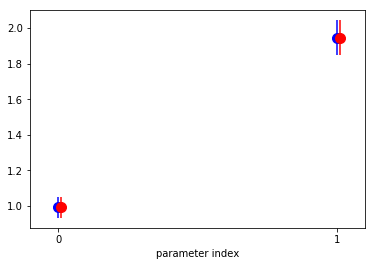

In [68]:
v = m.np_values()
ve = m.np_errors()
vm = m.np_merrors()
# show hesse errors
errorbar((0, 1), v, ve, fmt="ob");
# show minos errors
errorbar((0.01, 1.01), v, vm, fmt="or"); # add a little offset so that the error bars don't overlap
xlabel("parameter index")
xticks((0, 1))
xlim(-0.1, 1.1);

## Plotting

iminuit comes with buildin methods to draw the contours, like so:

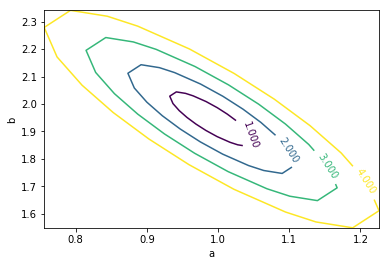

In [69]:
m.draw_mncontour('a','b', nsigma=4);  # nsigma=4 says: draw four contours from sigma=1 to 4

In [70]:
# get individual minos contours for plotting them yourself
param_a, param_b, ctr_xy = m.mncontour('a','b', sigma=2)
pprint(ctr_xy)

[(0.8734156787982194, 2.1119905244655923),
 (0.8824239281811733, 2.0582549073935645),
 (0.8999995907730525, 2.0066820348391534),
 (0.9218435068100065, 1.9569310517835712),
 (0.9468999238515619, 1.9087180561510038),
 (0.9750759205046066, 1.8618818581214405),
 (1.0065114362059702, 1.8171680505688939),
 (1.0428579642045699, 1.775532427960336),
 (1.0642095274128394, 1.7574662169785074),
 (1.090053180388609, 1.7467712260227068),
 (1.1085172042563223, 1.77789888252932),
 (1.099508954984477, 1.8316344996970808),
 (1.0819332924061547, 1.8832073723364517),
 (1.0600893763599784, 1.9329583554671692),
 (1.0350329592976528, 1.981171351170653),
 (1.0068569626156654, 2.028007549267934),
 (0.9754214468778168, 2.0727213568839993),
 (0.9390749188272809, 2.1143569795526957),
 (0.9177233555789281, 2.132423190556252),
 (0.8918797025367042, 2.1431181814681968)]


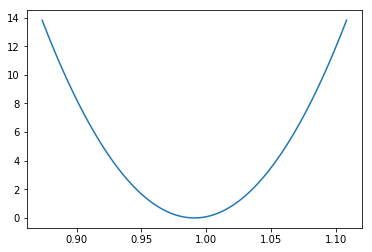

In [71]:
# 1D value Scan
a, fa = m.profile('a', subtract_min=True)
plot(a, fa);

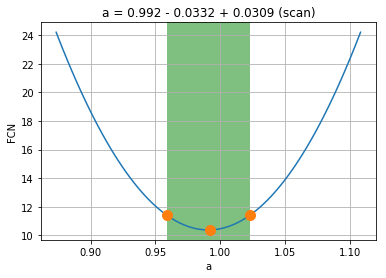

In [72]:
# we provide a convenience wrapper for drawing it which scans the region around the minimum as well
m.draw_profile('a');

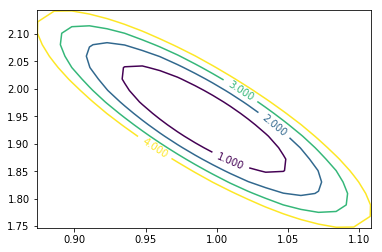

In [76]:
# beware: 2d contour is NOT a Minos contour, these are just contours of the fit function
x,y,z = m.contour('a', 'b', subtract_min=True)
cs = contour(x,y,z, (1, 2, 3, 4)) # these are not sigmas, just the contour values
clabel(cs);

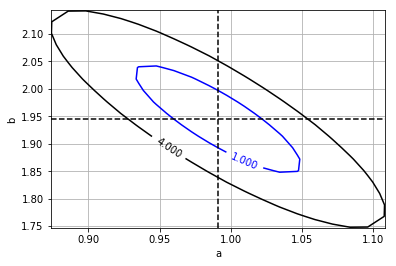

In [74]:
# convenience wrapper
m.draw_contour('a', 'b');